# Import 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import re

from glob import glob

# Premiers essais sur les données

In [2]:
# Allure des données générales sur les stations
info=pd.read_json('F:/work/download/stations_info.json')
data_info=pd.DataFrame(info.data.stations)
print('Nombre de stations :',len(data_info))
data_info.head()

Nombre de stations : 1454


,station_id,name,lat,lon,capacity,stationCode,rental_methods
0,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,16107,NaN
1,653222953,Mairie de Rosny-sous-Bois,48.871257,2.486581,30,31104,[CREDITCARD]
2,36255,Toudouze - Clauzel,48.879296,2.337360,21,9020,[CREDITCARD]
3,37815204,Mairie du 12ème,48.840855,2.387555,30,12109,NaN
4,17278902806,Rouget de L'isle - Watteau,48.778193,2.396302,0,44015,NaN


In [3]:
#Allure des données sur les vélos à un temps donné : 
data0=pd.read_json('F:/work/download/stations_status_2023_03_17_16_59_24.json')
data=pd.DataFrame(data0.data.stations)
data.head()

,stationCode,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,is_installed,is_returning,is_renting,last_reported
0,16107,213688169,7,7,"[{'mechanical': 4}, {'ebike': 3}]",28,28,1,1,1,1679066917
1,31104,653222953,8,8,"[{'mechanical': 6}, {'ebike': 2}]",20,20,1,1,1,1679066353
2,9020,36255,2,2,"[{'mechanical': 0}, {'ebike': 2}]",19,19,1,1,1,1679066838
3,12109,37815204,18,18,"[{'mechanical': 16}, {'ebike': 2}]",12,12,1,1,1,1679066819
4,44015,17278902806,0,0,"[{'mechanical': 0}, {'ebike': 0}]",0,0,0,0,0,1675935337


In [4]:
#On vérifie que certaines colonnes sont bien des doublons : 
print( (data.num_bikes_available != data.numBikesAvailable).any() , 
       (data.num_docks_available != data.numDocksAvailable).any() )

False False


In [5]:
# On va garder la version avec des undersocres plutot que des majuscules, vu que les autres champs sont pareils :
data=data.drop(['numBikesAvailable','numDocksAvailable'] , axis=1)

In [6]:
data.head()

,stationCode,station_id,num_bikes_available,num_bikes_available_types,num_docks_available,is_installed,is_returning,is_renting,last_reported
0,16107,213688169,7,"[{'mechanical': 4}, {'ebike': 3}]",28,1,1,1,1679066917
1,31104,653222953,8,"[{'mechanical': 6}, {'ebike': 2}]",20,1,1,1,1679066353
2,9020,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838
3,12109,37815204,18,"[{'mechanical': 16}, {'ebike': 2}]",12,1,1,1,1679066819
4,44015,17278902806,0,"[{'mechanical': 0}, {'ebike': 0}]",0,0,0,0,1675935337


# Génération du dataframe

Pour ajouter les données à chaque temps, on va garder la structure des fichiers à un temps donné pour la table totale, mais rajouter un champ 'time' au format datetime. 

Chaque station sera donc présente une fois par temps de mesure, et on pourra extraire ce temps à partir du stationCode ou station_id.

In [7]:
# Fonction pour lire et formater un fichier à partir de son chemin d'accès
def read_data(path_file: str) -> object:
    #Reads the dataframe in the input file
    data0=pd.read_json(path_file)
    data=pd.DataFrame(data0.data.stations)
    
    #Removes the dupe columns
    data=data.drop(['numBikesAvailable','numDocksAvailable'] , axis=1)
    
    #Determines the time the data was obtained
    date_str=re.search(r"\d{4}(_\d{2}){5}",path_file).group(0)
    date=datetime.datetime.strptime(date_str, '%Y_%m_%d_%H_%M_%S')
    
    #Adds a field for the time
    data['time']=date
    
    return data

In [8]:
# Fonction pour construire le dataframe à partir de tous les fichiers dans le répertoire data_rep
data_rep='F:/work/download/'
def build_df(data_rep=data_rep) -> object:
    #Read the list of files in data_rep: 
    list_files=glob(data_rep+'stations_status*.json')
    list_files=list_files
    first=1
    for file in list_files:
        if first :
            df=read_data(file)
            first=0
        else :
            df=pd.concat([df,read_data(file)])
    return df
    

In [9]:
df=build_df()

In [16]:
# import pickle
# file=open('F:/work/dataframe.pk', 'wb')
# pickle.dump(df, file)

# Analyse des résultats

## Allure générale

In [10]:
print(f'Dataframe avec {df.size} lignes')
df.describe()

Dataframe avec 17069960 lignes


,station_id,num_bikes_available,num_docks_available,is_installed,is_returning,is_renting,last_reported
count,1.706996e+06,1.706996e+06,1.706996e+06,1.706996e+06,1.706996e+06,1.706996e+06,1.706996e+06
mean,1.118766e+09,1.158710e+01,1.825622e+01,9.889959e-01,9.745981e-01,9.745981e-01,1.678419e+09
std,3.235794e+09,1.093475e+01,1.225352e+01,1.043218e-01,1.573426e-01,1.573426e-01,8.687308e+06
min,6.245000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.520582e+09
25%,5.592789e+07,3.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.679099e+09
50%,1.291442e+08,8.000000e+00,1.700000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.679135e+09
75%,6.530427e+08,1.700000e+01,2.600000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.679171e+09
max,1.736471e+10,7.800000e+01,6.700000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.679207e+09


In [11]:
df[df['station_id'] == 36255]

,stationCode,station_id,num_bikes_available,num_bikes_available_types,num_docks_available,is_installed,is_returning,is_renting,last_reported,time
2,9020,36255,4,"[{'mechanical': 1}, {'ebike': 3}]",17,1,1,1,1679066838,2023-03-17 16:30:22
2,9020,36255,5,"[{'mechanical': 1}, {'ebike': 4}]",16,1,1,1,1679066838,2023-03-17 16:34:22
2,9020,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838,2023-03-17 16:57:24
2,9020,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838,2023-03-17 16:59:24
2,9020,36255,2,"[{'mechanical': 0}, {'ebike': 2}]",19,1,1,1,1679066838,2023-03-17 17:01:24
...,...,...,...,...,...,...,...,...,...,...
2,9020,36255,1,"[{'mechanical': 0}, {'ebike': 1}]",20,1,1,1,1679207004,2023-03-19 07:56:08
2,9020,36255,1,"[{'mechanical': 0}, {'ebike': 1}]",20,1,1,1,1679207004,2023-03-19 07:58:09
2,9020,36255,1,"[{'mechanical': 0}, {'ebike': 1}]",20,1,1,1,1679207004,2023-03-19 08:00:10
2,9020,36255,1,"[{'mechanical': 0}, {'ebike': 1}]",20,1,1,1,1679207004,2023-03-19 08:02:09


## Variation au cours du temps

In [12]:
# sns.lineplot(data=df, x='time', y='num_bikes_available', hue='station_id')
#trop lent: je réduis le nombre de stations observées

In [31]:
import random
station_list=list(data_info.station_id)
station_red=random.sample(station_list,5)
df_red=df[df['station_id'].isin(station_red)]

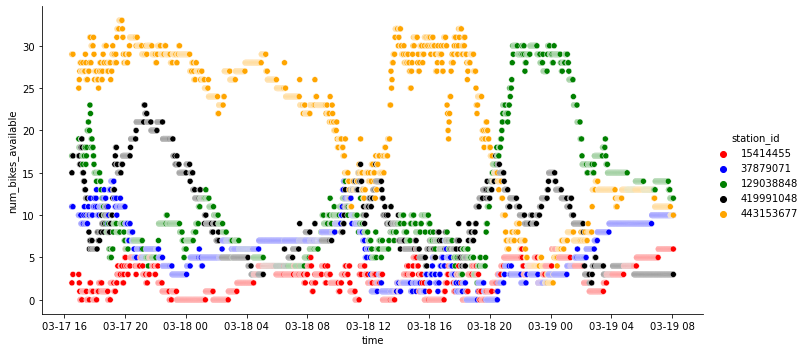

In [36]:
#à noter : lineplot est très lent, et ne renvoie rien même après quelques minutes, mais relplot est quasi instantanné
# sns.lineplot(data=df_red, x='time', y='num_bikes_available', hue='station_id')
sns.relplot(data=df_red, x='time', y='num_bikes_available', hue='station_id', height=5, aspect=2, 
            palette=['red','blue','green', 'black', 'orange'])



In [29]:
print(station_red)

[13373801574, 27363137, 66491388, 35471668, 66491385, 1559700274, 129048000, 653076373, 100921894, 82588494]


Pour ce petit échantillon, on voit bien des oscillations au cours du temps, mais les maximums ne sont pas toujours aux mêmes périodes. Il faudra sans doute séparer les stations par catégorie.